<a href="https://colab.research.google.com/github/thomas1608/phy466/blob/main/ExamAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf

print("Physical devices:", tf.config.list_physical_devices())
print("Logical GPU devices:", tf.config.list_logical_devices('GPU'))
print("GPU device name:", tf.test.gpu_device_name())

from tensorflow import keras # (changed) sticking to tf.keras
from tensorflow.keras import layers, ops, Model, random, regularizers, optimizers, models

import numpy as np
import h5py
import matplotlib.pyplot as plt
import random as py_random

SEED = 42  # for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)
py_random.seed(SEED)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPU devices: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU device name: /device:GPU:0


## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 0 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [ ]:
data_path = "./Galaxy10_DECals_64.h5"

# Download Galaxy10 DECaLS (HDF5) only if not already present
if not os.path.exists(data_path):
    !wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5 -O Galaxy10_DECals_64.h5
    print("Downloaded to:", data_path)
else:
    print("File already exists, reusing:", data_path)


File already exists, reusing: ./Galaxy10_DECals_64.h5


In [ ]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 64, 64, 3) (changed from 256 to 64)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images.astype("float32") / 255.0 # (Keras works more efficiently and uses less memory with float32)


print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)


Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [ ]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


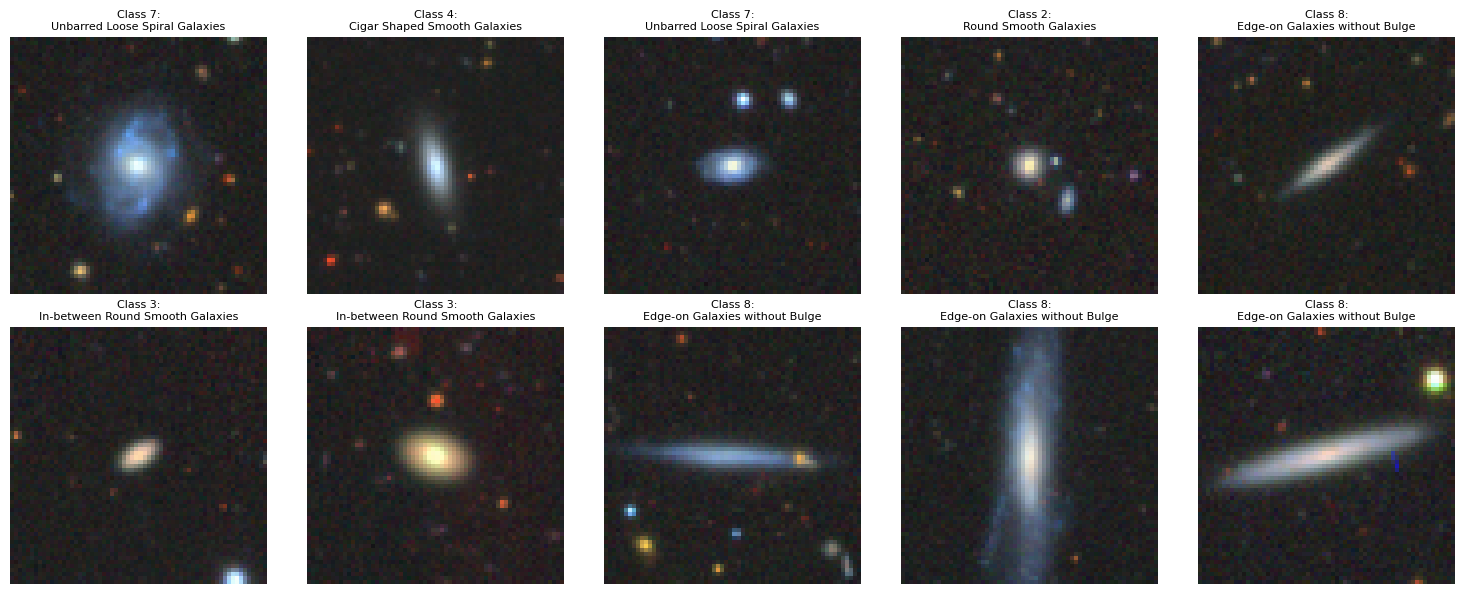

In [ ]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=2, n_cols=5):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [ ]:
# Create anomaly dataset: all class 0 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (16655, 64, 64, 3)
Anomaly images: (1081, 64, 64, 3)


In [ ]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [ ]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8327, 64, 64, 3) (8327,)
Val standard:   (4164, 64, 64, 3) (4164,)
Test standard:  (4164, 64, 64, 3) (4164,)


**EDA**

In [ ]:
with h5py.File(data_path, "r") as f:
    images = f["images"][()]      # (N, 64, 64, 3)
    labels = f["ans"][()]         # (N,)
    ra = f["ra"][()]
    dec = f["dec"][()]
    redshift = f["redshift"][()]
    pxscale = f["pxscale"][()]

Dataset structure & basic stats

In [ ]:
# Basic dataset overview
N, H, W, C = images.shape
print(f"Number of images: {N}")
print(f"Image size: {H}x{W}, channels: {C}")
print(f"Images dtype: {images.dtype}, range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Labels shape: {labels.shape}, dtype: {labels.dtype}")

# Per-channel statistics
channel_means = images.reshape(-1, C).mean(axis=0)
channel_stds = images.reshape(-1, C).std(axis=0)
print("\nPer-channel mean (R,G,B):", channel_means)
print("Per-channel std  (R,G,B):", channel_stds)

# Redshift NaN info
nan_z = np.isnan(redshift).sum()
print(f"\nRedshift NaNs: {nan_z} / {N}")


Number of images: 17736
Image size: 64x64, channels: 3
Images dtype: uint8, range: [0.000, 255.000]
Labels shape: (17736,), dtype: uint8

Per-channel mean (R,G,B): [42.70681794 41.46586604 40.5271324 ]
Per-channel std  (R,G,B): [29.11579624 27.62588207 25.58566254]

Redshift NaNs: 92 / 17736


## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

Build a CNN classifier on the standard dataset (9 classes)

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(1.0),
    layers.RandomZoom(0.1)
])


def build_simple_cnn(input_shape, n_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # --- Conv blocks ---
    x = layers.Conv2D(32, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(1e-3))(x)

    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.MaxPooling2D(2)(x)

    # --- Much smaller dense head ---
    x = layers.Flatten()(x)                          # 8192
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



# Build model
input_shape = X_train_std.shape[1:]  # (64, 64, 3)
model = build_simple_cnn(input_shape, n_classes)
model.summary()


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,969 (8.37 MB)

 Trainable params: 2,192,969 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

Train on train set, validate on val set

In [ ]:
# Train the CNN
batch_size = 64
epochs = 100

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    ),
]


history = model.fit(
    X_train_std, y_train_std,
    validation_data=(X_val_std, y_val_std),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2390 - loss: 6.0424 - val_accuracy: 0.4923 - val_loss: 1.8433
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4501 - loss: 1.9362 - val_accuracy: 0.5137 - val_loss: 1.7124
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5028 - loss: 1.7494 - val_accuracy: 0.5740 - val_loss: 1.5634
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5382 - loss: 1.6509 - val_accuracy: 0.6061 - val_loss: 1.4746
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5468 - loss: 1.6087 - val_accuracy: 0.6287 - val_loss: 1.3699
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5916 - loss: 1.4723 - val_accuracy: 0.6573 - val_loss: 1.2934
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5950 - loss: 1.4453 - val_accuracy: 0.6741 - val_loss: 1.2504
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6129 - loss: 1.3965 - 

Plot training history (loss & accuracy)

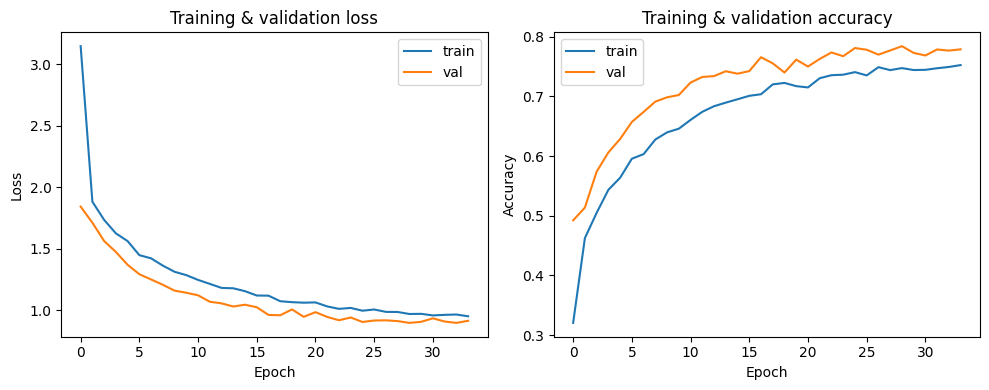

In [ ]:
# Plot training history: loss & accuracy
history_dict = history.history

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_dict["loss"], label="train")
plt.plot(history_dict["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_dict["accuracy"], label="train")
plt.plot(history_dict["val_accuracy"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & validation accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Predictions on the standard test set

In [ ]:
y_proba_test = model.predict(X_test_std)
y_pred_test = np.argmax(y_proba_test, axis=1)

print("Test accuracy (overall):", np.mean(y_pred_test == y_test_std))

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test accuracy (overall): 0.7785782901056676


Compute ROC curves (one-vs-rest) on the standard test set

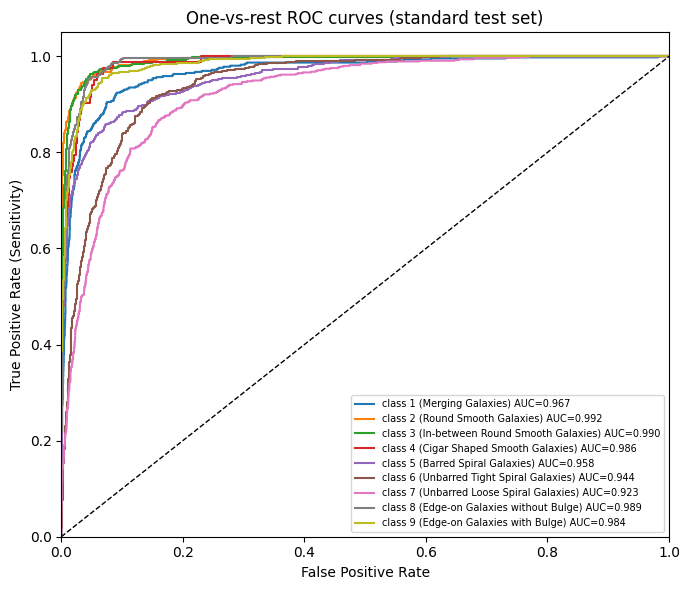

In [ ]:
classes = np.unique(y_test_std)
plt.figure(figsize=(7,6))

for c in classes:
    # binary labels: 1 if this class, 0 otherwise
    y_true_c = (y_test_std == c).astype(int)
    y_score_c = y_proba_test[:, c]

    fpr, tpr, _ = roc_curve(y_true_c, y_score_c)
    roc_auc = auc(fpr, tpr)

    original_label = inv_label_map[int(c)]
    label_name = class_names[original_label]
    plt.plot(fpr, tpr, lw=1.5, label=f"class {original_label} ({label_name}) AUC={roc_auc:.3f}")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("One-vs-rest ROC curves (standard test set)")
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()


Compute confusion matrix for standard test

In [ ]:
cm = confusion_matrix(y_test_std, y_pred_test, normalize="true") * 100

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format=".1f")
plt.title("Confusion matrix (standard test set, %)")
plt.show()


NameError: name 'confusion_matrix' is not defined

In [ ]:
from sklearn.metrics import classification_report, f1_score

y_proba = model.predict(X_test_std, verbose=0)
y_pred  = np.argmax(y_proba, axis=1)

macro_f1 = f1_score(y_test_std, y_pred, average="macro")
print(f"Macro F1 score (CNN, test): {macro_f1:.3f}")

print("\nPer-class metrics (CNN, test):")
print(classification_report(
    y_test_std,
    y_pred,
    target_names=std_labels,
    digits=3,
))


Macro F1 score (CNN, test): 0.753

Per-class metrics (CNN, test):


NameError: name 'std_labels' is not defined

## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

Train a convolutional autoencoder on standard train set only

In [ ]:
def build_conv_autoencoder(input_shape=(64, 64, 3)):
    # ----- Encoder (all conv, no Dense) -----
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)   # 64 -> 32

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    encoded = layers.MaxPooling2D((2, 2), padding="same", name="latent")(x)  # 32 -> 16

    # ----- Decoder (mirror of encoder) -----
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(encoded)
    x = layers.UpSampling2D((2, 2))(x)                   # 16 -> 32

    x = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(x)
    x = layers.UpSampling2D((2, 2))(x)                   # 32 -> 64

    outputs = layers.Conv2D(
        3, (3, 3),
        padding="same",
        activation="sigmoid",   # images in [0,1]
        name="reconstruction",
    )(x)

    autoencoder = keras.Model(inputs, outputs, name="conv_autoencoder_simple")
    autoencoder.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="mse",
    )
    return autoencoder

# Build model
input_shape = X_train_std.shape[1:]  # (64, 64, 3)
autoencoder = build_conv_autoencoder(input_shape)
autoencoder.summary()


Model: "conv_autoencoder_dense_latent"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4096)           │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Conv2D)         │ (None, 64, 64, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,355 (720.14 KB)

 Trainable params: 184,355 (720.14 KB)

 Non-trainable params: 0 (0.00 B)

Plot training history


In [ ]:
# Train autoencoder on *standard* train set only
batch_size = 64
epochs = 50

ae_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )
]

history_ae = autoencoder.fit(
    X_train_std, X_train_std,               # input == target
    validation_data=(X_val_std, X_val_std),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=ae_callbacks,
)

# Plot training history (loss only, since autoencoder has no accuracy)
hist = history_ae.history

start_epoch = 5  # 1-based epoch index to start plotting from
start_idx = start_epoch - 1  # convert to 0-based index

epochs_range = range(start_epoch, len(hist["loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, hist["loss"][start_idx:], label="train")
plt.plot(epochs_range, hist["val_loss"][start_idx:], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title(f"Autoencoder training & validation loss (from epoch {start_epoch})")
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0508 - val_loss: 0.0067
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 12/50
136/136 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

Compute reconstruction loss (MSE) per image for:
- Standard test set
- Anomaly dataset (class 4)

In [ ]:
# Reconstruction on standard test set
X_test_std_recon = autoencoder.predict(X_test_std, batch_size=64, verbose=1)
recon_loss_std = np.mean(
    np.square(X_test_std_recon - X_test_std),
    axis=(1, 2, 3)
)

# Reconstruction on anomaly set (class 4) – note: never seen during training
anom_recon = autoencoder.predict(anom_images, batch_size=64, verbose=1)
recon_loss_anom = np.mean(
    np.square(anom_recon - anom_images),
    axis=(1, 2, 3)
)

print("Reconstruction loss (standard test):")
print("  mean =", recon_loss_std.mean(), "std =", recon_loss_std.std())
print("Reconstruction loss (anomaly):")
print("  mean =", recon_loss_anom.mean(), "std =", recon_loss_anom.std())


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Reconstruction loss (standard test):
  mean = 0.0030480747 std = 0.0020025529
Reconstruction loss (anomaly):
  mean = 0.0026078748 std = 0.0015697578


Plot histograms of reconstruction losses

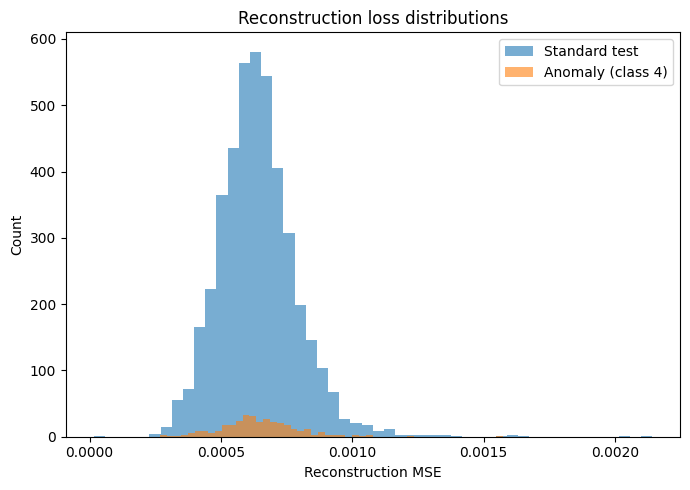

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(recon_loss_std,  bins=50, alpha=0.6, label="Standard test")
plt.hist(recon_loss_anom, bins=50, alpha=0.6, label="Anomaly (class 4)")
plt.xlabel("Reconstruction MSE")
plt.ylabel("Count")
plt.title("Reconstruction loss distributions")
plt.legend()
plt.tight_layout()
plt.show()

Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

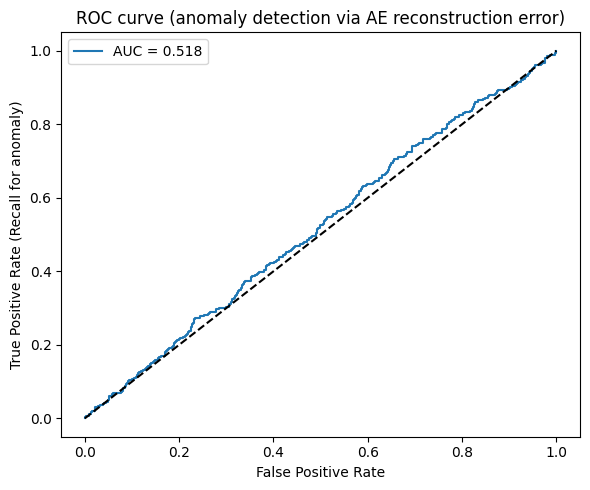

In [ ]:
# Build labels and scores
y_true_ae = np.concatenate([
    np.zeros_like(recon_loss_std, dtype=int),   # 0 = standard
    np.ones_like(recon_loss_anom, dtype=int),   # 1 = anomaly
])
scores_ae = np.concatenate([recon_loss_std, recon_loss_anom])

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true_ae, scores_ae)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall for anomaly)")
plt.title("ROC curve (anomaly detection via AE reconstruction error)")
plt.legend()
plt.tight_layout()
plt.show()




Best threshold (Youden's J): 0.0005795761
Confusion matrix (AE anomaly detection):
[[1495 2856]
 [  98  236]]


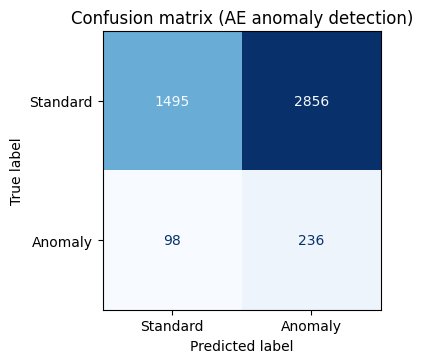

In [ ]:
# Choose threshold using Youden's J statistic
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thresh = thresholds[best_idx]
print("Best threshold (Youden's J):", best_thresh)

# Binary predictions: 1 = anomaly if recon loss >= threshold
y_pred_ae = (scores_ae >= best_thresh).astype(int)

cm_ae = confusion_matrix(y_true_ae, y_pred_ae)
print("Confusion matrix (AE anomaly detection):")
print(cm_ae)

fig, ax = plt.subplots(figsize=(4,4))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_ae,
    display_labels=["Standard", "Anomaly"],
)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion matrix (AE anomaly detection)")
plt.tight_layout()
plt.show()


In [ ]:
# F1 for anomaly class only
f1_anom = f1_score(y_true_ae, y_pred_ae, pos_label=1)
print(f"Anomaly F1 score (AE): {f1_anom:.3f}")

# Per-class metrics: class 0 = Standard, class 1 = Anomaly
print("\nPer-class metrics (AE anomaly detection):")
print(classification_report(
    y_true_ae,
    y_pred_ae,
    target_names=["Standard", "Anomaly"],
    digits=3,
))


Anomaly F1 score (AE): 0.138

Per-class metrics (AE anomaly detection):
              precision    recall  f1-score   support

    Standard      0.938     0.344     0.503      4351
     Anomaly      0.076     0.707     0.138       334

    accuracy                          0.369      4685
   macro avg      0.507     0.525     0.320      4685
weighted avg      0.877     0.369     0.477      4685



## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images

Build a VAE with convolutional encoder/decoder (trained on standard train set)

In [ ]:
# -------- Sampling layer --------
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent vector."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim   = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


# -------- Encoder: same style, adapted to 64x64x3 --------
latent_dim = 256

# ----- Encoder: use *same* conv structure as AE -----
enc_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(16, 3, padding="same", activation="relu")(enc_inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)        # 64 -> 32
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)        # 32 -> 16

shape_before_flatten = x.shape[1:]   # (16, 16, 32)
x = layers.Flatten()(x)              # 8192
x = layers.Dense(256, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(enc_inputs, [z_mean, z_log_var, z], name="encoder")

# ----- Decoder: mirror AE decoder -----
dec_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(np.prod(shape_before_flatten), activation="relu")(dec_inputs)
x = layers.Reshape(shape_before_flatten)(x)               # (16, 16, 32)

x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.UpSampling2D((2, 2))(x)                        # 16 -> 32
x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
x = layers.UpSampling2D((2, 2))(x)                        # 32 -> 64

dec_outputs = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(x)
decoder = keras.Model(dec_inputs, dec_outputs, name="decoder")

decoder.summary()


# -------- VAE model class --------
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=0.1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs, training=None):
        """Forward pass used by `predict`, `__call__`, etc."""
        z_mean, z_log_var, z = self.encoder(inputs, training=training)
        reconstruction = self.decoder(z, training=training)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            sq_err = tf.square(data - reconstruction)
            per_example = tf.reduce_sum(sq_err, axis=(1, 2, 3))
            recon_loss = tf.reduce_mean(per_example)

            kl = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl = tf.reduce_mean(tf.reduce_sum(kl, axis=1))

            total_loss = recon_loss + self.beta * kl

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())



Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8192)           │     2,105,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,119,651 (8.09 MB)

 Trainable params: 2,119,651 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -------- Train on standard galaxies --------
# Make sure X_train_std is float32 and in [0,1]
# e.g. X_train_std = X_train / 255.0 (which you already do)

history_vae = vae.fit(
    X_train_std,
    epochs=50,          # you can tune
    batch_size=64,      # same as your CNN
    verbose=1,
)

Epoch 1/50


NameError: name 'reconstruction_loss' is not defined

Plot training history

In [ ]:
hist = history_vae.history

plt.figure(figsize=(6, 4))
plt.plot(hist["loss"], label="train total loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE training loss")
plt.legend()
plt.tight_layout()
plt.show()

Generate new galaxy images from the VAE

In [ ]:
def generate_random_galaxies(decoder, latent_dim, n=10):
    # Sample random points in latent space ~ N(0, I)
    z_random = np.random.normal(size=(n, latent_dim)).astype("float32")

    # Decode them into images
    generated = decoder.predict(z_random)

    # Plot
    plt.figure(figsize=(n * 1.6, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = generated[i]
        # clip just in case of slight numerical issues
        img = np.clip(img, 0.0, 1.0)
        plt.imshow(img)  # RGB, no cmap
        plt.axis("off")
    plt.show()


Visualize some generated images

In [ ]:
generate_random_galaxies(decoder, latent_dim=latent_dim, n=10)

In [ ]:
# Reconstruct test images
recon_test = vae.predict(X_test_std, batch_size=64, verbose=1)

# Per-image MSE
sq_err = np.square(X_test_std - recon_test)
per_image_mse = np.mean(sq_err, axis=(1, 2, 3))

print("Reconstruction MSE on standard test set:")
print("  mean :", float(per_image_mse.mean()))
print("  std  :", float(per_image_mse.std()))
print("  min  :", float(per_image_mse.min()))
print("  max  :", float(per_image_mse.max()))

plt.figure(figsize=(6,4))
plt.hist(per_image_mse, bins=50)
plt.xlabel("Per-image MSE")
plt.ylabel("Count")
plt.title("VAE reconstruction error distribution (test set)")
plt.tight_layout()
plt.show()


In [ ]:
recon_test_ae = autoencoder.predict(X_test_std, batch_size=64, verbose=1)
sq_err_ae = np.square(X_test_std - recon_test_ae)
per_image_mse_ae = np.mean(sq_err_ae, axis=(1, 2, 3))

print("CAE test MSE mean:", float(per_image_mse_ae.mean()))
print("VAE test MSE mean:", float(per_image_mse.mean()))
